Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
!pip install -q IPython
!pip install -q ipykernel
!pip install -q watermark
!pip install -q matplotlib
!pip install -q sklearn
!pip install -q pandas
!pip install -q pydot
!pip install -q hiddenlayer
!pip install -q graphviz

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101


# Network in Network CIFAR-10 Classifier

based on 

- Lin, Min, Qiang Chen, and Shuicheng Yan. "Network in network." arXiv preprint arXiv:1312.4400 (2013).

## Imports

In [3]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [4]:
torch.tensor([1]).device

device(type='cpu')

## Model Settings

In [5]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 100

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [6]:
##########################
### CIFAR-10 Dataset
##########################


# Note transforms.ToTensor() scales input images
# to 0-1 range


train_indices = torch.arange(0, 49000)
valid_indices = torch.arange(49000, 50000)


train_and_valid = datasets.CIFAR10(root='data', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)


test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


#####################################################
### Data Loaders
#####################################################

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

#####################################################

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])


In [7]:
##########################
### MODEL
##########################


class NiN(nn.Module):
    def __init__(self, num_classes):
        super(NiN, self).__init__()
        self.num_classes = num_classes
        self.classifier = nn.Sequential(
                nn.Conv2d(3, 192, kernel_size=5, stride=1, padding=2),
                nn.ReLU(inplace=True),
                nn.Conv2d(192, 160, kernel_size=1, stride=1, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(160,  96, kernel_size=1, stride=1, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                nn.Dropout(0.5),

                nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2),
                nn.ReLU(inplace=True),
                nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                nn.ReLU(inplace=True),
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Dropout(0.5),

                nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(192,  10, kernel_size=1, stride=1, padding=0),
                nn.ReLU(inplace=True),
                nn.AvgPool2d(kernel_size=8, stride=1, padding=0),

                )

    def forward(self, x):
        x = self.classifier(x)
        logits = x.view(x.size(0), self.num_classes)
        probas = torch.softmax(logits, dim=1)
        return logits, probas

## Training without Pinned Memory

In [8]:
torch.manual_seed(RANDOM_SEED)

model = NiN(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_opset9.py:1310: UserWarning: Dropout is a training op and should not be exported in inference mode. Make sure to call eval() on the model, and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


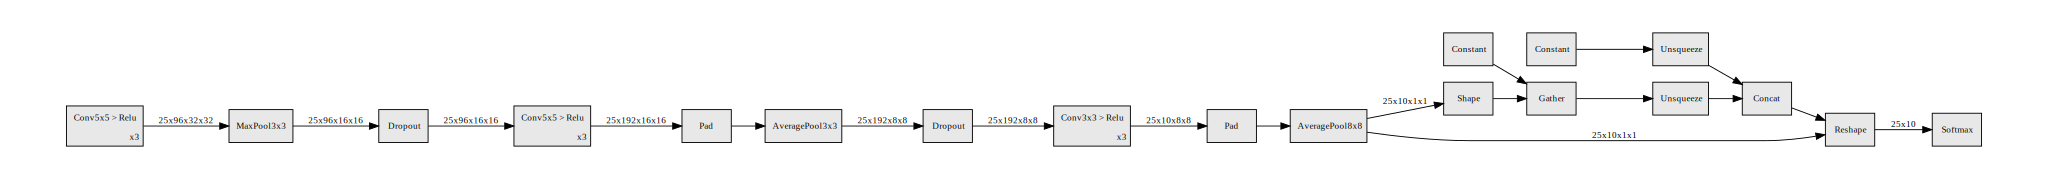

In [10]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([25, 3, 32, 32]).to(DEVICE))

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

In [ ]:
%watermark -iv